<a href="https://colab.research.google.com/github/FrancoArenas1/RedesNeuronales/blob/main/Proyecto_Programacion_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales y Deep Learning: Proyecto de Programacion

**Alumnos:**
- Juan Alex Castro Gumiel
- Franco Arenas Garrido

**Proyecto:** 
- Nombre: Cassava Leaf Disease Classification
- Objetivo: Identificar el tipo de enfermedad presente en una imagen de hoja de yuca
- Enlace Kaggle: https://www.kaggle.com/competitions/cassava-leaf-disease-classification/overview/description

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import json
import random

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

## Carga del Conjunto de Datos

In [4]:
def CargarDatosKaggle():
    # Instalamos la ultima version de la API de Kaggle en Colab
    !pip install --upgrade --force-reinstall --no-deps kaggle

    # Seleccionamos el API Token personal descargado de Kaggle
    from google.colab import files
    files.upload()

    # Creamos un directorio para copiar el fichero kaggle.json
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Descargamos el dataset previa aceptacion de la competicion
    !kaggle competitions download -c cassava-leaf-disease-classification

    # Creemos un nuevo directorio para descomprimir los datos
    !mkdir dataset

    # Descomprimimos los datos en el nuevo directorio creado
    !unzip cassava-leaf-disease-classification.zip -d dataset

    # listamos el contenido de una carpeta como verificacion
    !ls dataset/test_images

In [ ]:
# Ejecutamos la funcion para cargar el conjunto de los datos
CargarDatosKaggle()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c0c260a276547ee883cd2844dc59316e22fc70397dacf32c01cd49f7888d71cc
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


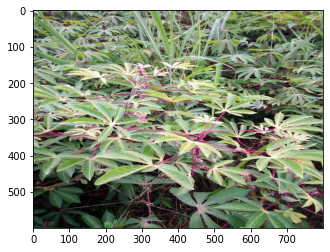

In [ ]:
# Ploteamos una imagen para verificar el acceso a nuestro dataset
img = cv2.imread('dataset/test_images/2216849948.jpg', cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Inspeccion del Conjunto de Datos

In [ ]:
# Exploramos el contenido de la carpeta de nuestro dataset
os.listdir('dataset')

['test_tfrecords',
 'label_num_to_disease_map.json',
 'train.csv',
 'test_images',
 'train_tfrecords',
 'sample_submission.csv',
 'train_images']

In [ ]:
# Revisamos las etiquetas definidas en el archivo JSON del dataset
with open('dataset/label_num_to_disease_map.json', 'r') as rj:
    label = json.load(rj)
print(label)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [ ]:
# Cargamos un dataframe con los datos de train de nuestro dataset
df_train = pd.read_csv('dataset/train.csv')
df_train

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


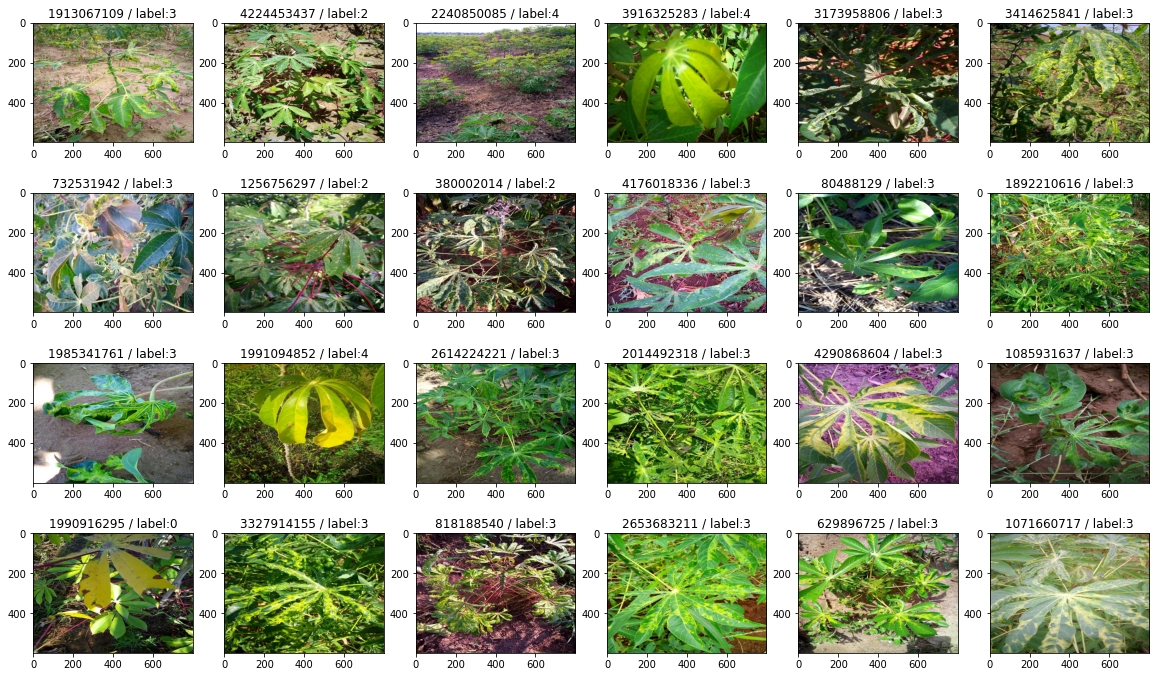

In [ ]:
# Inspeccionamos aleatoriamente imagenes y etiquetas del dataset
fig = plt.figure(figsize=(20,12))
for num in range(1, 25):
    fig.add_subplot(4, 6, num)
    ran = random.randint(0, len(df_train)-1)
    img = cv2.imread('dataset/train_images/' + df_train.iloc[ran][0], cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(str(df_train.iloc[ran][0]).replace(".jpg","") + ' / label:' + str(df_train.iloc[ran][1]))

## Acondicionamiento de los Datos

In [ ]:
# Re-escalamos las imagenes a 128x128 y las convertimos a array
imagenes = list()
etiquetas = list()
dimension = 128

for numero in range(0, len(df_train)-1):
    imagen = load_img('dataset/train_images/' + df_train.iloc[numero][0], target_size=(dimension, dimension))
    imagenes.append(img_to_array(imagen))
    etiquetas.append(df_train.iloc[numero][1])

In [ ]:
# Convertimos a un array de Numpy y normalizamos a escala 0 a 1
X = np.asarray(imagenes)
y = np.asarray(etiquetas)

X = X / 255

print(X.shape)
print(y.shape)

(21396, 128, 128, 3)
(21396,)


In [ ]:
# Inspeccionamos aleatoriamente imagenes y etiquetas del Ndarray
fig = plt.figure(figsize=(24,14))
for num in range(1, 25):
    fig.add_subplot(4, 6, num)
    ran = random.randint(0, len(X)-1)
    plt.imshow(X[ran])
    plt.title(label[str(y[ran])])

In [ ]:
# Aplicamos One-Hot Encoding para poder minimizar el error
sample = random.randint(0, len(X)-1)
print(y[sample])

lb = LabelBinarizer()
y = lb.fit_transform(y)
print(y[sample])
print(y.shape)

1
[0 1 0 0 0]
(21396, 5)


In [ ]:
# Dividimos el dataset en entrenamiento, evaluacion y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(14977, 128, 128, 3) (4493, 128, 128, 3) (1926, 128, 128, 3)
(14977, 5) (4493, 5) (1926, 5)


In [ ]:
# Creamos un contenedor para realizar Data Augmentation
generador = ImageDataGenerator(
            rotation_range=20, # grados de rotacion aleatoria
            width_shift_range=0.1, # fraccion del total para mover la imagen
            height_shift_range=0.1, # fraccion del total para mover la imagen
            zoom_range=0.1, # rango de zoom que se puede aplicar
            horizontal_flip=True) # girar imagenes horizontalmente (eje vertical)

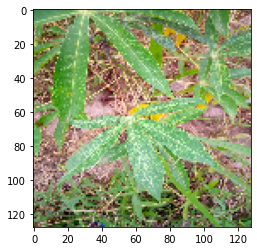

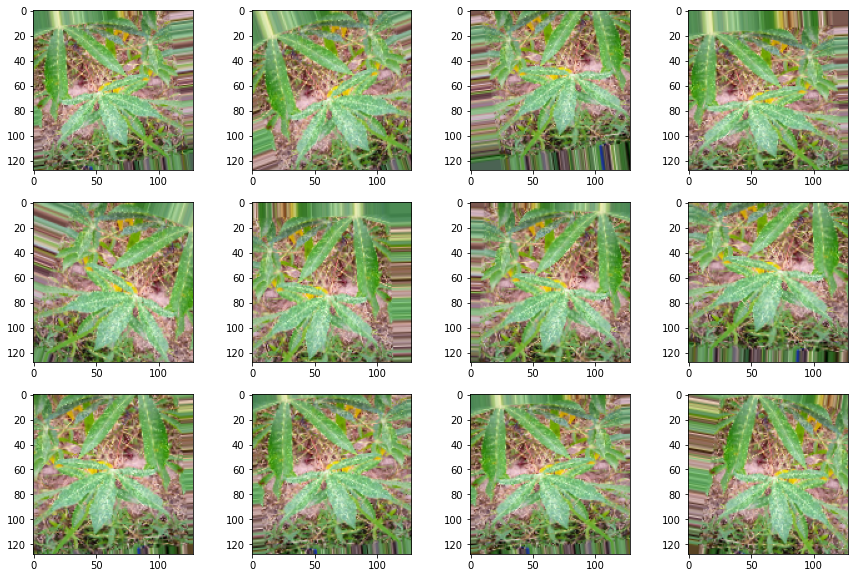

In [ ]:
# Seleccionamos una imagen para testear nuestro generador
sample = random.randint(0, len(X_train)-1)
plt.imshow(X_train[sample])
plt.show()

fig = plt.figure(figsize=(15,10))
num = 1
for batch in generador.flow(X_train[sample].reshape((1, 128, 128, 3)), batch_size=1):
    fig.add_subplot(3, 4, num)
    plt.imshow(batch[0])
    num += 1
    if num == 13: break

## Estrategia 1: From Scratch

Se realizaron varios experimentos preliminares antes de conseguir nuestra mejor version, adjuntamos la tabla de resumen de experimientos:

<img src="https://drive.google.com/uc?export=view&id=1k-trUPw6zC2TFdlYPdpLj8jjKEI0NiMf">

### Desarrollo de la Arquitectura

In [ ]:
# Definimos las entradas del modelo en base a las dimensiones del dataset
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# BASE MODEL
# Capa 1: Conv > Batch > Pool
c1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs) 
c1 = BatchNormalization()(c1) 
c1 = MaxPooling2D(pool_size=(2, 2))(c1) 

# Capa 2: Conv > Batch > Dropout
c2 = Conv2D(64, (3, 3), padding="same", activation="relu")(c1) 
c2 = BatchNormalization()(c2) 
c2 = Dropout(0.2)(c2) 

# Capa 3: Conv > Batch > Pool > Dropout
c3 = Conv2D(64, (3, 3), padding="same", activation="relu")(c2) 
c3 = BatchNormalization()(c3) 
c3 = MaxPooling2D(pool_size=(2, 2))(c3) 
c3 = Dropout(0.3)(c3) 

# Capa 4: Conv > Batch > Pool > Dropout
c4 = Conv2D(256, (3, 3), padding="same", activation="relu")(c3) 
c4 = BatchNormalization()(c4) 
c4 = MaxPooling2D(pool_size=(2, 2))(c4)
c4 = Dropout(0.2)(c4) 

# Capa 5: Conv > Batch > Pool > Dropout
c5 = Conv2D(256, (3, 3), padding="same", activation="relu")(c4) 
c5 = BatchNormalization()(c5) 
c5 = MaxPooling2D(pool_size=(2, 2))(c5) 
c5 = Dropout(0.3)(c5) 

# Capa 6: Conv > Batch
c6 = Conv2D(256, (3, 3), padding="same", activation="relu")(c5)
c6 = BatchNormalization()(c6)

# Capa 7: Conv > Batch > Pool > Dropout
c7 = Conv2D(512, (3, 3), padding="same", activation="relu")(c6)
c7 = BatchNormalization()(c7)
c7 = MaxPooling2D(pool_size=(2, 2))(c7)
c7 = Dropout(0.2)(c7)

# TOP MODEL
# Capa 1: Flatten > Dense > Batch > Dropout
f1 = Flatten()(c7)
f1 = Dense(512, activation="relu")(f1)
f1 = BatchNormalization()(f1)
f1 = Dropout(0.3)(f1)

# Capa 2: Dense > Batch > Dropout
f2 = Dense(256, activation="relu")(f1)
f2 = BatchNormalization()(f2)
f2 = Dropout(0.2)(f2)

# Capa 3: Dense > Batch
f3 = Dense(64, activation="relu")(f2)
f3 = BatchNormalization()(f3)

# Clasificador con activacion Softmax
outputs = Dense(5, activation="softmax")(f3)

# Unimos las entradas y el modelo (parametros inputs y ouputs)
modelo = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Desplegamos el resumen de nuestro modelo propuesto
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256   

In [ ]:
# Compilamos definiendo la perdida, el optimizador y las metricas
modelo.compile(loss="categorical_crossentropy", 
               optimizer=Adam(learning_rate=0.001), 
               metrics=["accuracy"])

In [ ]:
# Realizamos el entrenamiento de nuestro modelo de red neuronal
epocas = 20
resumen = modelo.fit(generador.flow(X_train, y_train, batch_size=64), epochs=epocas, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
235/235 [==============================] - 53s 224ms/step - loss: 0.4064 - accuracy: 0.8508 - val_loss: 1.3192 - val_accuracy: 0.5600
Epoch 2/20
235/235 [==============================] - 53s 224ms/step - loss: 0.4011 - accuracy: 0.8502 - val_loss: 0.8490 - val_accuracy: 0.7294
Epoch 3/20
235/235 [==============================] - 53s 223ms/step - loss: 0.3958 - accuracy: 0.8532 - val_loss: 0.7226 - val_accuracy: 0.7794
Epoch 4/20
235/235 [==============================] - 52s 223ms/step - loss: 0.3754 - accuracy: 0.8617 - val_loss: 0.7396 - val_accuracy: 0.7805
Epoch 5/20
235/235 [==============================] - 52s 223ms/step - loss: 0.3768 - accuracy: 0.8606 - val_loss: 0.9235 - val_accuracy: 0.7182
Epoch 6/20
235/235 [==============================] - 52s 221ms/step - loss: 0.3607 - accuracy: 0.8647 - val_loss: 0.7758 - val_accuracy: 0.7554
Epoch 7/20
235/235 [==============================] - 52s 222ms/step - loss: 0.3600 - accuracy: 0.8681 - val_loss: 1.1593 - val_ac

### Monitorizacion del Entrenamiento

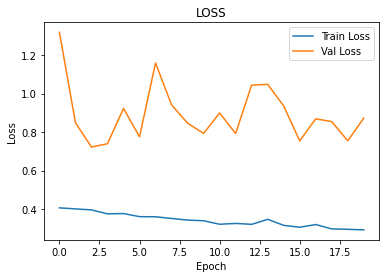

In [ ]:
# Desplegamos la informacion obtenida de la perdida del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["loss"], label="Train Loss")
plt.plot(np.arange(0, epocas), resumen.history["val_loss"], label="Val Loss")
plt.title("LOSS")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

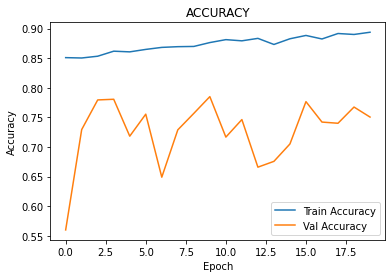

In [ ]:
# Desplegamos la informacion de resumen del accuracy del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, epocas), resumen.history["val_accuracy"], label="Val Accuracy")
plt.title("ACCURACY")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### Evaluación del Modelo Predictivo

In [ ]:
# Evaluamos el modelo de prediccion con las imagenes de test
predicciones = modelo.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1), predicciones.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.49      0.45      0.47       105
           1       0.69      0.49      0.58       174
           2       0.66      0.42      0.51       216
           3       0.91      0.92      0.92      1211
           4       0.48      0.75      0.58       220

    accuracy                           0.78      1926
   macro avg       0.64      0.60      0.61      1926
weighted avg       0.79      0.78      0.78      1926



## Estrategia 2: Red Pre-Entrenada VGG16

Se realizaron varios experimentos preliminares antes de conseguir nuestra mejor version, adjuntamos la tabla de resumen de experimientos: 

<img src="https://drive.google.com/uc?export=view&id=1E9yzvVqg9aQMIgA5Y3Uu3CnjmSXokLGT">

### Transfer Learning

#### Desarrollo de la Arquitectura

In [ ]:
# Cargamos la topologia Base Model de la VGG16 sin Top Model
base_vgg = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (128, 128, 3))

base_vgg.summary()

In [ ]:
# Creamos el Top Model y congelamos todas las capas convolucionales
base_vgg.trainable = False

modelo_pre = Sequential()
modelo_pre.add(base_vgg)

modelo_pre.add(layers.Flatten()) # vector de representacion
modelo_pre.add(layers.Dense(512, activation='relu'))
modelo_pre.add(layers.Dense(256, activation='relu'))
modelo_pre.add(layers.Dense(64, activation='relu'))
modelo_pre.add(layers.Dense(5, activation='softmax'))

modelo_pre.summary()

In [ ]:
# Compilamos definiendo la perdida, el optimizador y las metricas
modelo_pre.compile(loss="categorical_crossentropy", 
               optimizer=Adam(learning_rate=0.001), 
               metrics=["accuracy"])

In [ ]:
# Realizamos el entrenamiento de nuestro modelo de red neuronal
epocas = 40
resumen = modelo_pre.fit(generador.flow(X_train, y_train, batch_size=64), epochs=epocas, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/40
235/235 [==============================] - 72s 251ms/step - loss: 1.0237 - accuracy: 0.6331 - val_loss: 0.9670 - val_accuracy: 0.6648
Epoch 2/40
235/235 [==============================] - 57s 244ms/step - loss: 0.9235 - accuracy: 0.6659 - val_loss: 0.8937 - val_accuracy: 0.6795
Epoch 3/40
235/235 [==============================] - 58s 248ms/step - loss: 0.8911 - accuracy: 0.6738 - val_loss: 0.8875 - val_accuracy: 0.6746
Epoch 4/40
235/235 [==============================] - 58s 246ms/step - loss: 0.8864 - accuracy: 0.6754 - val_loss: 0.9078 - val_accuracy: 0.6802
Epoch 5/40
235/235 [==============================] - 58s 245ms/step - loss: 0.8679 - accuracy: 0.6820 - val_loss: 0.8829 - val_accuracy: 0.6710
Epoch 6/40
235/235 [==============================] - 57s 244ms/step - loss: 0.8494 - accuracy: 0.6900 - val_loss: 0.9111 - val_accuracy: 0.6604
Epoch 7/40
235/235 [==============================] - 57s 243ms/step - loss: 0.8423 - accuracy: 0.6901 - val_loss: 0.8510 - val_ac

#### Monitorizacion del Entrenamiento

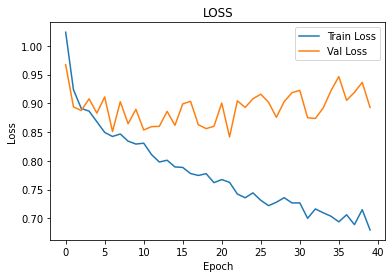

In [ ]:
# Desplegamos la informacion obtenida de la perdida del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["loss"], label="Train Loss")
plt.plot(np.arange(0, epocas), resumen.history["val_loss"], label="Val Loss")
plt.title("LOSS")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

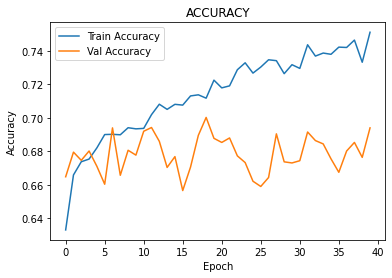

In [ ]:
# Desplegamos la informacion de resumen del accuracy del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, epocas), resumen.history["val_accuracy"], label="Val Accuracy")
plt.title("ACCURACY")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#### Evaluacion del Modelo Predictivo

In [ ]:
# Evaluamos el modelo de prediccion con las imagenes de test
predicciones = modelo_pre.predict(X_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), predicciones.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       105
           1       0.39      0.47      0.43       174
           2       0.43      0.13      0.20       216
           3       0.81      0.89      0.85      1211
           4       0.40      0.46      0.43       220

    accuracy                           0.68      1926
   macro avg       0.50      0.44      0.45      1926
weighted avg       0.66      0.68      0.66      1926



### Fine Tuning

#### Desarrollo de la Arquitectura

In [ ]:
# BASE MODEL
# Cargamos la topologia Base Model de la VGG16 sin Top Model
base_vgg = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (128, 128, 3))

base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Congelamos las capas de los 3 primeros bloques, el 4 y 5 se re-entrenan
for layer in base_vgg.layers: 
  if layer.name == 'block5_conv1': 
    break 
  layer.trainable = False 
  print('Capa Congelada: ' + layer.name) 

Capa Congelada: input_2
Capa Congelada: block1_conv1
Capa Congelada: block1_conv2
Capa Congelada: block1_pool
Capa Congelada: block2_conv1
Capa Congelada: block2_conv2
Capa Congelada: block2_pool
Capa Congelada: block3_conv1
Capa Congelada: block3_conv2
Capa Congelada: block3_conv3
Capa Congelada: block3_pool
Capa Congelada: block4_conv1
Capa Congelada: block4_conv2
Capa Congelada: block4_conv3
Capa Congelada: block4_pool


In [ ]:
# TOP MODEL
# Cogemos la última capa del model y le añadimos nuestro clasificador 
last = base_vgg.layers[-1].output 

# Capa 1: Flatten > Dense > Batch > Dropout
f1 = Flatten()(last)
f1 = Dense(512, activation="relu")(f1)
f1 = BatchNormalization()(f1)
f1 = Dropout(0.3)(f1)

# Capa 2: Dense > Batch > Dropout
f2 = Dense(256, activation="relu")(f1)
f2 = BatchNormalization()(f2)
f2 = Dropout(0.2)(f2)

# Capa 3: Dense > Batch
f3 = Dense(64, activation="relu")(f2)
f3 = BatchNormalization()(f3)

# Clasificador con activacion Softmax
outputs = Dense(5, activation="softmax")(f3)

# Unimos las entradas y el modelo (parametros inputs y ouputs)
modelo_ft = Model(base_vgg.input, outputs=outputs)

modelo_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Compilamos definiendo la perdida, el optimizador y las metricas
modelo_ft.compile(optimizer='sgd', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
# Realizamos el entrenamiento de nuestro modelo de red neuronal
epocas = 40
resumen = modelo_ft.fit(generador.flow(X_train, y_train, batch_size=64), epochs=epocas, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/40
235/235 [==============================] - 60s 243ms/step - loss: 1.2251 - accuracy: 0.5838 - val_loss: 1.2836 - val_accuracy: 0.6388
Epoch 2/40
235/235 [==============================] - 57s 242ms/step - loss: 0.9609 - accuracy: 0.6646 - val_loss: 1.2291 - val_accuracy: 0.5724
Epoch 3/40
235/235 [==============================] - 57s 241ms/step - loss: 0.8915 - accuracy: 0.6794 - val_loss: 0.8479 - val_accuracy: 0.6982
Epoch 4/40
235/235 [==============================] - 57s 241ms/step - loss: 0.8503 - accuracy: 0.6897 - val_loss: 0.8469 - val_accuracy: 0.6949
Epoch 5/40
235/235 [==============================] - 57s 240ms/step - loss: 0.8262 - accuracy: 0.6962 - val_loss: 0.8415 - val_accuracy: 0.6888
Epoch 6/40
235/235 [==============================] - 57s 241ms/step - loss: 0.8042 - accuracy: 0.7038 - val_loss: 0.8265 - val_accuracy: 0.7020
Epoch 7/40
235/235 [==============================] - 56s 240ms/step - loss: 0.7889 - accuracy: 0.7111 - val_loss: 0.8442 - val_ac

#### Monitorizacion del Entrenamiento

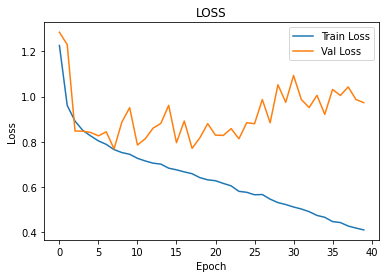

In [ ]:
# Desplegamos la informacion obtenida de la perdida del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["loss"], label="Train Loss")
plt.plot(np.arange(0, epocas), resumen.history["val_loss"], label="Val Loss")
plt.title("LOSS")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

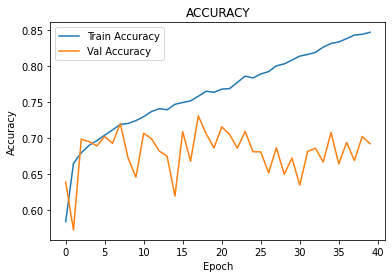

In [ ]:
# Desplegamos la informacion de resumen del accuracy del modelo
plt.figure()
plt.plot(np.arange(0, epocas), resumen.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, epocas), resumen.history["val_accuracy"], label="Val Accuracy")
plt.title("ACCURACY")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#### Evaluacion del Modelo Predictivo

In [ ]:
# Evaluamos el modelo de prediccion con las imagenes de test
predicciones = modelo_ft.predict(X_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), predicciones.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.48      0.38      0.42       105
           1       0.49      0.57      0.53       174
           2       0.48      0.30      0.37       216
           3       0.88      0.86      0.87      1211
           4       0.37      0.55      0.44       220

    accuracy                           0.71      1926
   macro avg       0.54      0.53      0.53      1926
weighted avg       0.72      0.71      0.71      1926



## Estrategia 3: Red Pre-Entrenada [XYZ]

### Desarrollo de la Arquitectura

In [1]:
## ACONDICIONANDO DATOS COMO EN LA XCEPTION
from tf.keras.applications.xception.preprocess_input import xception.preprocess_input

SyntaxError: ignored

### Monitorizacion del Entrenamiento

### Evaluacion del Modelo Predictivo

## Conclusiones de los Modelos Creados